In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.svm import SVC
import time
from sklearn.datasets import make_moons
import itertools
import warnings
from matplotlib import pyplot as plt

In [38]:
def metrics(y_test, y_pred):
  conf_matrix = confusion_matrix(y_test, y_pred)

  TN = conf_matrix[0, 0]
  FP = conf_matrix[0, 1]
  FN = conf_matrix[1, 0]
  TP = conf_matrix[1, 1]

  sensitivity = TP / (TP + FN)
  specificity = TN / (TN + FP)

  return conf_matrix, sensitivity, specificity

#SVM

Implement support vector machine learning utilizing linear, radial, and polynomial kernel functions **kernel='linear'**, **kernel='rbf'**, and **kernel='poly'**

$$L = \sum_{i} \lambda_i - \frac{1}{2} \sum_{i} \sum_{j} \lambda_i \lambda_j y_i y_j K(\vec{x}_i, \vec{x}_j)$$

Where:
*   $\lambda_i \in \mathbb{R}_{\geq 0}$ - weight of the \(i\)-th support vector
*   $\vec{x}_i \in \mathbb{R}^D$ - \(i\)-th sample from the training set
*   $y_i \in \{-1, 1\}$ - \(i\)-th label from the training set
*   $K(\vec{x}_i, \vec{x}_j)$ - Kernel function (linear, RBF, or polynomial)



In [39]:
def linear_kernel(x_i, x_j, gamma, deg, r):
    return np.dot(x_i, x_j)

def rbf_kernel(x_i, x_j, gamma, deg, r):
    return np.exp(-gamma * np.dot(x_i - x_j, x_i - x_j))

def poly_kernel(x_i, x_j, gamma, deg, r):
    return (gamma * np.dot(x_i, x_j) + r) ** deg

In [40]:
def cost_function(lambdas, y, K):
    n = len(y)
    result = 0
    for i in range(n):
        for j in range(n):
            result += lambdas[i] * lambdas[j] * y[i] * y[j] * K[i, j]
    result = np.sum(lambdas) - 0.5 * result
    return -result

In [41]:
def SVM(X, y, kernel, gamma=None, deg=3, r=0, c=1):

    # Number of samples and features
    n_samples, n_features = X.shape

    # Calculate gamma if not provided
    if gamma == None:
        gamma = 1 / (n_features * X.var())

    # Matrix with computed kernel
    K = np.zeros(shape=(n_samples, n_samples))

    # Compute kernel matrix
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = kernel(X[i], X[j], gamma, deg, r)

    # Initialize lambdas and constraints
    initial_lambdas = np.random.rand(n_samples)
    bounds = [(0, c)] * n_samples
    constraints = {'type': 'eq', 'fun': lambda lambdas, y: np.dot(y, lambdas), 'args': (y,)}

    # Minimize the reward function
    solution = minimize(cost_function, initial_lambdas, args=(y, K), bounds=bounds, constraints=constraints)

    # Extract support vectors and their properties
    lambdas = solution.x
    sv = (lambdas > 1e-5) & (lambdas <= c)
    sv_x = X[sv]
    sv_y = y[sv]
    sv_lambda = lambdas[sv]
    sv_index = np.arange(len(lambdas))[sv]

    # Calculate bias term
    b = 0
    for i in range(len(sv_y)):
        b += sv_y[i]
        b -= np.sum(sv_lambda * sv_y * K[sv_index[i], sv])

    b = b / len(sv_lambda)

    # Calculate weights if the kernel is linear
    if kernel == linear_kernel:
        w = np.zeros(n_features)
        for i in range(len(sv_lambda)):
            w += sv_lambda[i] * sv_x[i] * sv_y[i]
        return sv_x, sv_y, sv_lambda, b, w

    # If the kernel is not linear, return None for weights
    w = None
    return sv_x, sv_y, sv_lambda, b, w


In [42]:
def pred(X, sv_x, sv_y, sv_lambda, b, kernel, w=None, gamma=None, deg=3, r=0, c=1):

    n_samples, n_features = X.shape
    if gamma == None:
        gamma = 1 / (n_features* X.var())

    # If the kernel is linear and "w" is defined, the value of f(x) is determined by f(x) = X * w + b
    if kernel == linear_kernel:
        return np.sign(np.dot(X, w) + b)

    else:
        # Otherwise, it is determined by f(x) = sum_i{sum_sv{lambda_sv y_sv K(x_i, x_sv)}}
        y_predict = np.zeros(len(X))
        for k in range(len(X)):
            for lam, x_sv, y_sv in zip(sv_lambda, sv_x, sv_y):
                y_predict[k] += lam * y_sv * kernel(X[k], x_sv, gamma, deg, r)

        return np.sign(y_predict + b)

##Linera kernel

Let's compare our own implementation with the one we can find in sklearn

In [43]:
X, y = make_classification(n_samples=120, n_features=2, n_informative=2, n_redundant=0,
                            n_clusters_per_class=1, random_state=254468)
y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=254468)

In [44]:
start = time.time()
sv_x, sv_y, sv_lambda, b, we = SVM(X_train, y_train, kernel=linear_kernel)
end = time.time()

print(f'It took {end - start} seconds to make our SVM implementation')

y_pred = pred(X_test, sv_x, sv_y, sv_lambda, b, kernel=linear_kernel,w = we)


x0 = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
x1 = -(we[0]  * x0 - b) / we[1]

margin_x1 = x1 + 1 / np.sqrt(np.sum(we ** 2))
margin_x2 = x1 - 1 / np.sqrt(np.sum(we ** 2))

It took 14.773428916931152 seconds to make our SVM implementation


In [45]:
svm_sklearn = SVC(kernel='linear')

start = time.time()
svm_sklearn.fit(X_train, y_train)
end = time.time()

print(f'It took {end - start} seconds to make sklearn SVM implementation')

y_pred_sklearn = svm_sklearn.predict(X_test)

w_sklearn = svm_sklearn.coef_[0]
b_sklearn = svm_sklearn.intercept_[0]
x0_sklearn = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
x1_sklearn = -(w_sklearn[0] / w_sklearn[1]) * x0_sklearn - b_sklearn / w_sklearn[1]

margin_x1_sklearn = x1_sklearn + 1 / np.sqrt(np.sum(w_sklearn ** 2))
margin_x2_sklearn = x1_sklearn - 1 / np.sqrt(np.sum(w_sklearn ** 2))

It took 0.005124330520629883 seconds to make sklearn SVM implementation


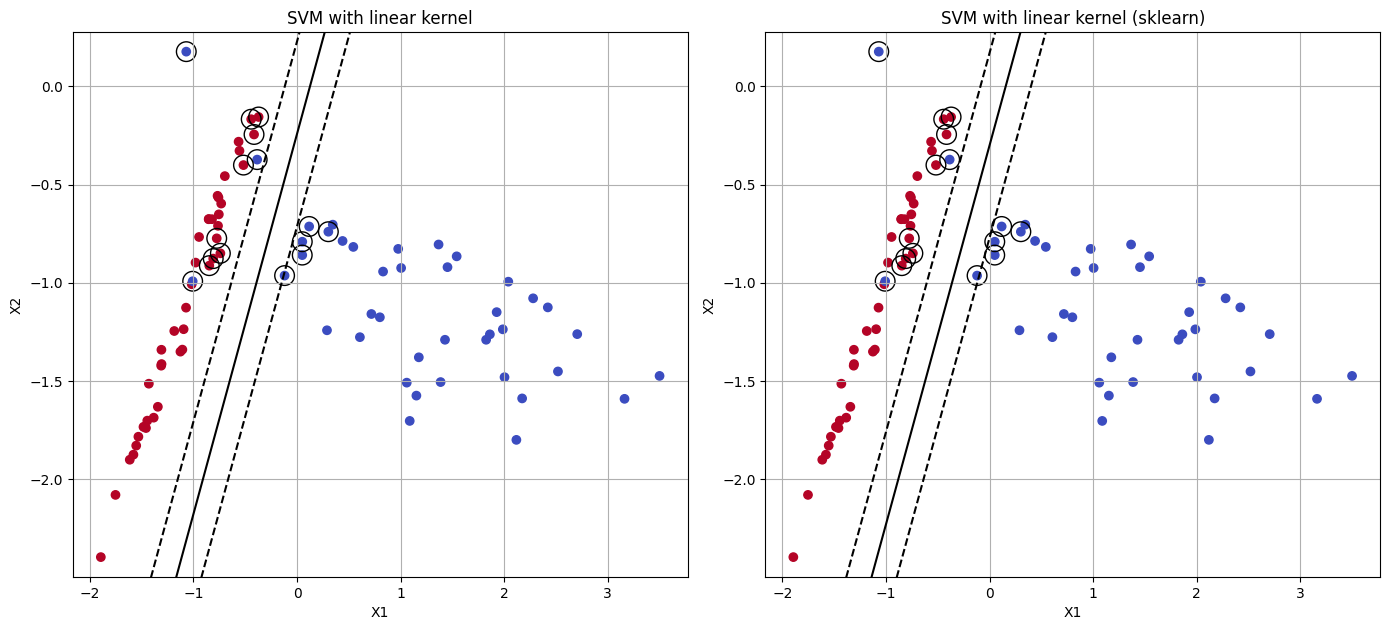

In [46]:
y_min = np.min(X[:, 1])-0.1
y_max = np.max(X[:, 1])+0.1

plt.figure(figsize=(14, 12))

plt.subplot(2, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm')
plt.plot(x0, x1, 'black')
plt.plot(x0, margin_x1, 'k--')
plt.plot(x0, margin_x2, 'k--')
plt.scatter(sv_x[:, 0], sv_x[:, 1], s=200, facecolors='none', edgecolors='k', label='Wektory wspierające')
plt.title('SVM with linear kernel')
plt.xlabel('X1')
plt.ylabel('X2')
plt.ylim(y_min, y_max)
plt.grid(True)

plt.subplot(2, 2, 2)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm')
plt.plot(x0_sklearn, x1_sklearn, 'black')
plt.plot(x0_sklearn, margin_x1_sklearn, 'k--')
plt.plot(x0_sklearn, margin_x2_sklearn, 'k--')
plt.scatter(svm_sklearn.support_vectors_[:, 0], svm_sklearn.support_vectors_[:, 1], s=200, facecolors='none', edgecolors='k', label='Wektory wspierające')
plt.title('SVM with linear kernel (sklearn)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.ylim(y_min, y_max)
plt.grid(True)


plt.tight_layout()
plt.show()

In [47]:
conf_matrix_anl, sensitivity_anl, specificity_anl = metrics(y_test, y_pred)

print("conf_matrix:")
print(conf_matrix_anl)
print("sensitivity:", sensitivity_anl)
print("specificity:", specificity_anl)

conf_matrix:
[[18  0]
 [ 2 16]]
sensitivity: 0.8888888888888888
specificity: 1.0


In [48]:
conf_matrix, sensitivity, specificity = metrics(y_test, y_pred_sklearn)

print("conf_matrix:")
print(conf_matrix)
print("sensitivity:", sensitivity)
print("specificity:", specificity)

conf_matrix:
[[17  1]
 [ 2 16]]
sensitivity: 0.8888888888888888
specificity: 0.9444444444444444


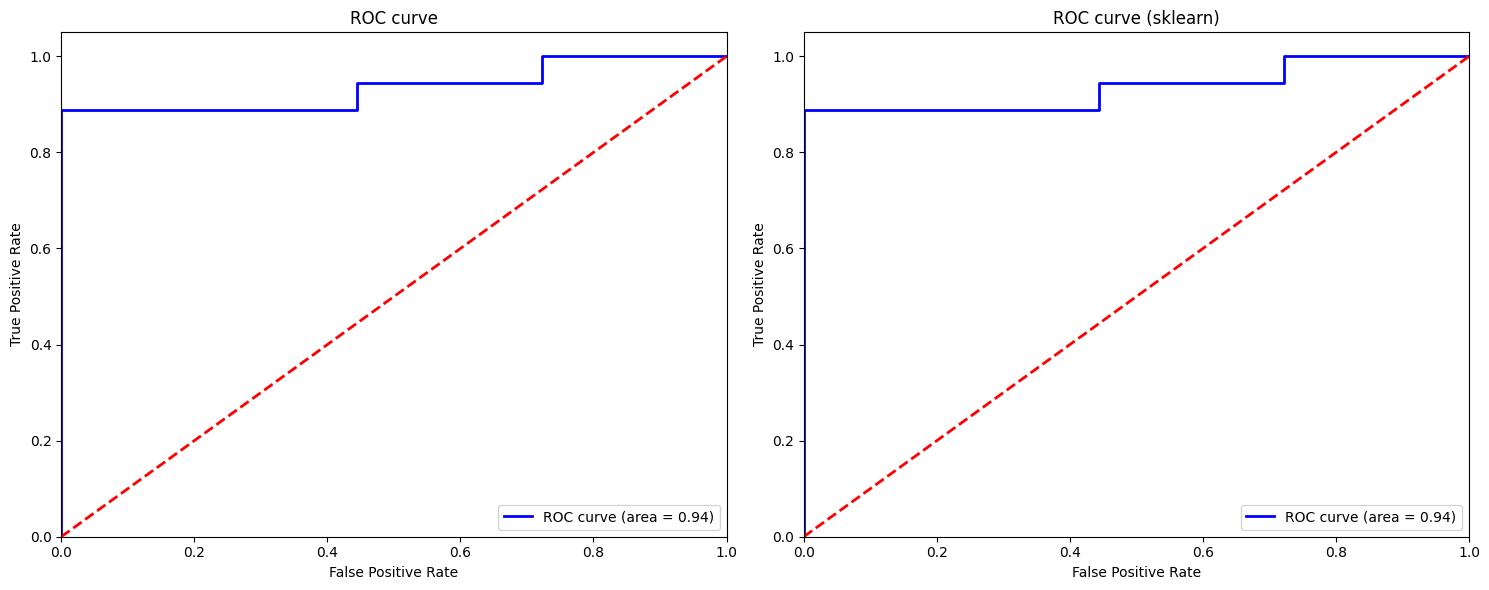

In [49]:
y_scores_anl = X_test @ we
fpr_anl, tpr_anl, _ = roc_curve(y_test, y_scores_anl)
roc_auc_anl = roc_auc_score(y_test, y_scores_anl)

y_scores_sklearn = svm_sklearn.decision_function(X_test)
fpr_sklearn, tpr_sklearn, _ = roc_curve(y_test, y_scores_sklearn)
roc_auc_sklearn = roc_auc_score(y_test, y_scores_sklearn)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr_anl, tpr_anl, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_anl)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(fpr_sklearn, tpr_sklearn, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_sklearn)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (sklearn)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [50]:
X, y = make_moons(n_samples=100, random_state=254468)

y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=254468)

In [51]:
sv_x, sv_y, sv_lambda, b, we = SVM(X_train, y_train, kernel=linear_kernel)
y_pred = pred(X_test, sv_x, sv_y, sv_lambda, b, kernel=linear_kernel,w = we)

x0 = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
x1 = -(we[0]  * x0 - b) / we[1]

margin_x1 = x1 + 1 / np.sqrt(np.sum(we ** 2))
margin_x2 = x1 - 1 / np.sqrt(np.sum(we ** 2))

In [52]:
svm_sklearn = SVC(kernel='linear')
svm_sklearn.fit(X_train, y_train)
y_pred_sklearn = svm_sklearn.predict(X_test)

w_sklearn = svm_sklearn.coef_[0]
b_sklearn = svm_sklearn.intercept_[0]
x0_sklearn = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
x1_sklearn = -(w_sklearn[0] / w_sklearn[1]) * x0_sklearn - b_sklearn / w_sklearn[1]

margin_x1_sklearn = x1_sklearn + 1 / np.sqrt(np.sum(w_sklearn ** 2))
margin_x2_sklearn = x1_sklearn - 1 / np.sqrt(np.sum(w_sklearn ** 2))

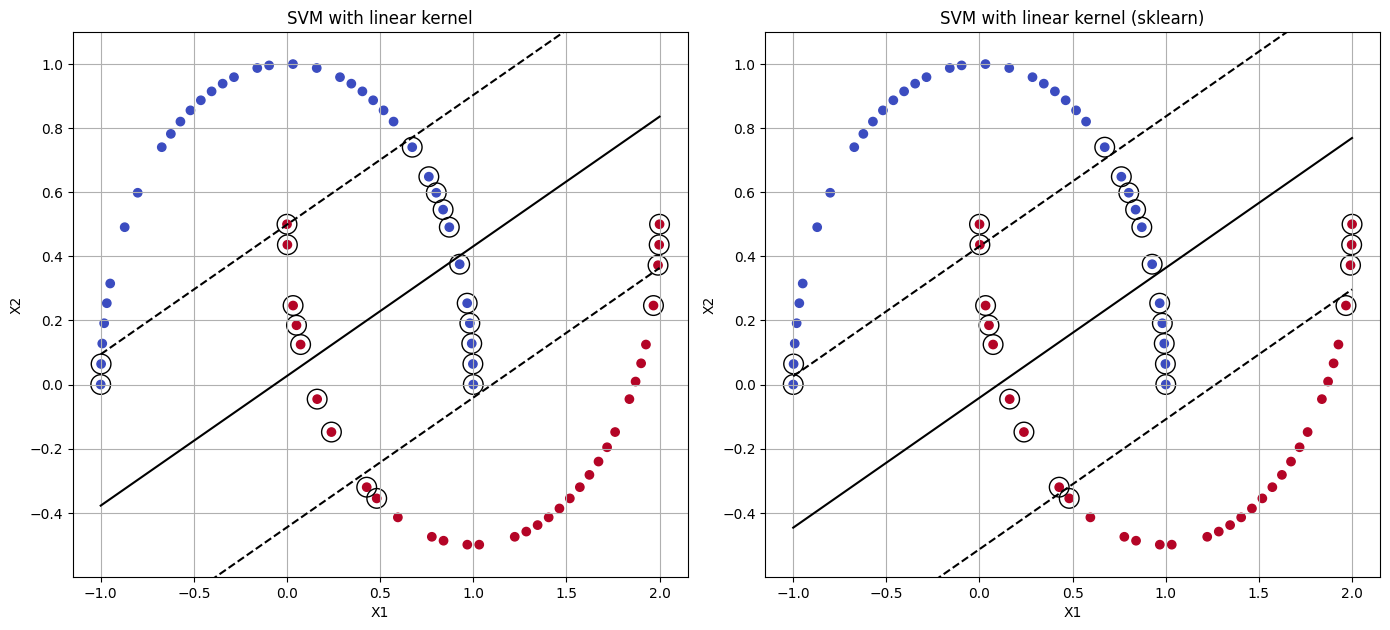

In [53]:
y_min = np.min(X[:, 1])-0.1
y_max = np.max(X[:, 1])+0.1

plt.figure(figsize=(14, 12))

plt.subplot(2, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm')
plt.plot(x0, x1, 'black')
plt.plot(x0, margin_x1, 'k--')
plt.plot(x0, margin_x2, 'k--')
plt.scatter(sv_x[:, 0], sv_x[:, 1], s=200, facecolors='none', edgecolors='k', label='Wektory wspierające')
plt.title('SVM with linear kernel')
plt.xlabel('X1')
plt.ylabel('X2')
plt.ylim(y_min, y_max)
plt.grid(True)

plt.subplot(2, 2, 2)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm')
plt.plot(x0_sklearn, x1_sklearn, 'black')
plt.plot(x0_sklearn, margin_x1_sklearn, 'k--')
plt.plot(x0_sklearn, margin_x2_sklearn, 'k--')
plt.scatter(svm_sklearn.support_vectors_[:, 0], svm_sklearn.support_vectors_[:, 1], s=200, facecolors='none', edgecolors='k', label='Wektory wspierające')
plt.title('SVM with linear kernel (sklearn)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.ylim(y_min, y_max)
plt.grid(True)

plt.tight_layout()
plt.show()

In [54]:
conf_matrix, sensitivity, specificity = metrics(y_test, y_pred)

print("conf_matrix:")
print(conf_matrix_anl)
print("sensitivity:", sensitivity_anl)
print("specificity:", specificity_anl)

conf_matrix:
[[18  0]
 [ 2 16]]
sensitivity: 0.8888888888888888
specificity: 1.0


In [55]:
conf_matrix, sensitivity, specificity = metrics(y_test, y_pred_sklearn)

print("Macierz pomyłek (sklearn):")
print(conf_matrix)
print("sensitivity:", sensitivity)
print("specificity:", specificity)

Macierz pomyłek (sklearn):
[[12  1]
 [ 3 14]]
sensitivity: 0.8235294117647058
specificity: 0.9230769230769231


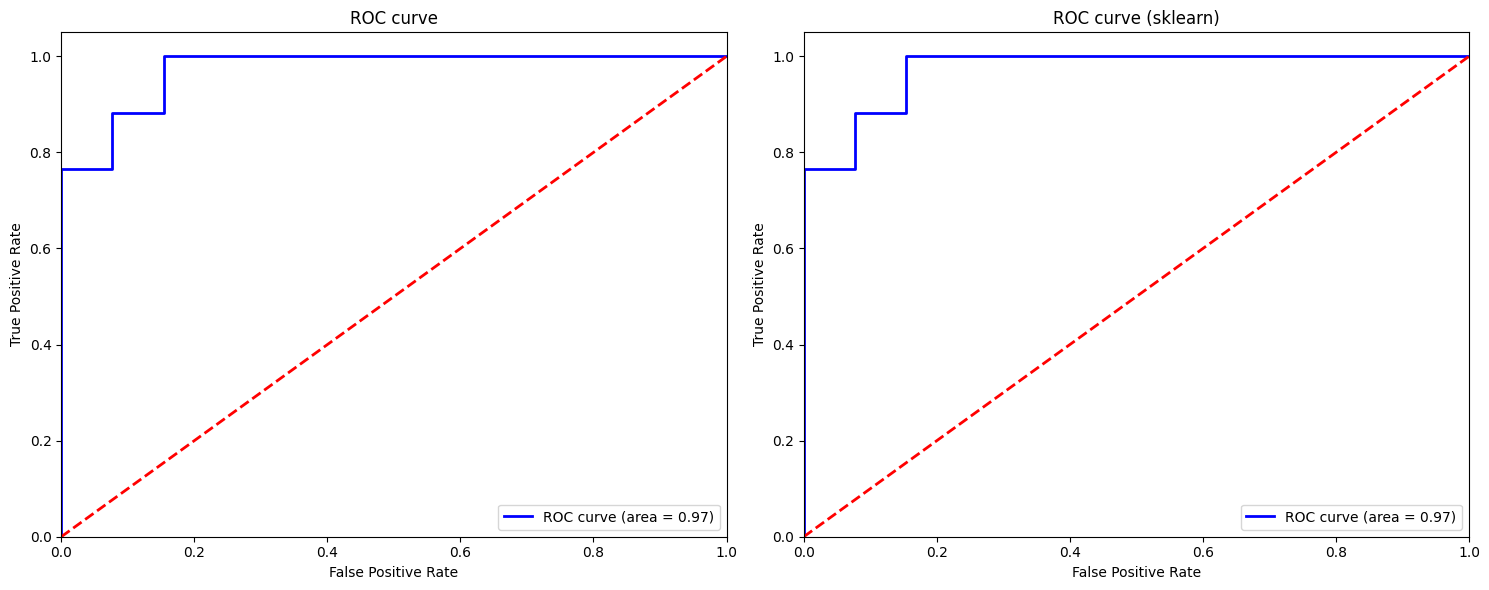

In [56]:
y_scores_anl = X_test @ we
fpr_anl, tpr_anl, _ = roc_curve(y_test, y_scores_anl)
roc_auc_anl = roc_auc_score(y_test, y_scores_anl)

y_scores_sklearn = svm_sklearn.decision_function(X_test)
fpr_sklearn, tpr_sklearn, _ = roc_curve(y_test, y_scores_sklearn)
roc_auc_sklearn = roc_auc_score(y_test, y_scores_sklearn)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr_anl, tpr_anl, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_anl)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(fpr_sklearn, tpr_sklearn, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_sklearn)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (sklearn)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

Before we try the remaining kernels, first define a function that will help us determine the margins.

In [57]:
def calculate_decision_boundary(X, sv_x, sv_y, sv_lambda, b, kernel, gamma=None, deg=3, r=1):
    n_samples, n_features = X.shape
    if gamma == None:
        gamma = 1 / (n_features* X.var())

    Z = np.zeros(len(X))

    for k in range(len(X)):
        for lam, x_sv, y_sv in zip(sv_lambda, sv_x, sv_y):
            Z[k] += lam * y_sv * kernel(X[k], x_sv, gamma, deg, r)

    return Z + b

##RBF

In [58]:
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0,
                            n_clusters_per_class=1, random_state=254468)
y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=254468)

In [59]:
sv_x, sv_y, sv_lambda, b, w = SVM(X_train, y_train, kernel=rbf_kernel, gamma = None)
y_pred = pred(X_test, sv_x, sv_y, sv_lambda, b, kernel=rbf_kernel)

x0 = np.linspace(np.min(X_train[:, 0]), np.max(X_train[:, 0]), 100)
x1 = np.linspace(np.min(X_train[:, 1]), np.max(X_train[:, 1]), 100)
X0, X1 = np.meshgrid(x0, x1)
XX = np.array([X0.ravel(), X1.ravel()]).T

Z = calculate_decision_boundary(XX, sv_x, sv_y, sv_lambda, b, rbf_kernel, gamma = None)
Z = Z.reshape(X0.shape)

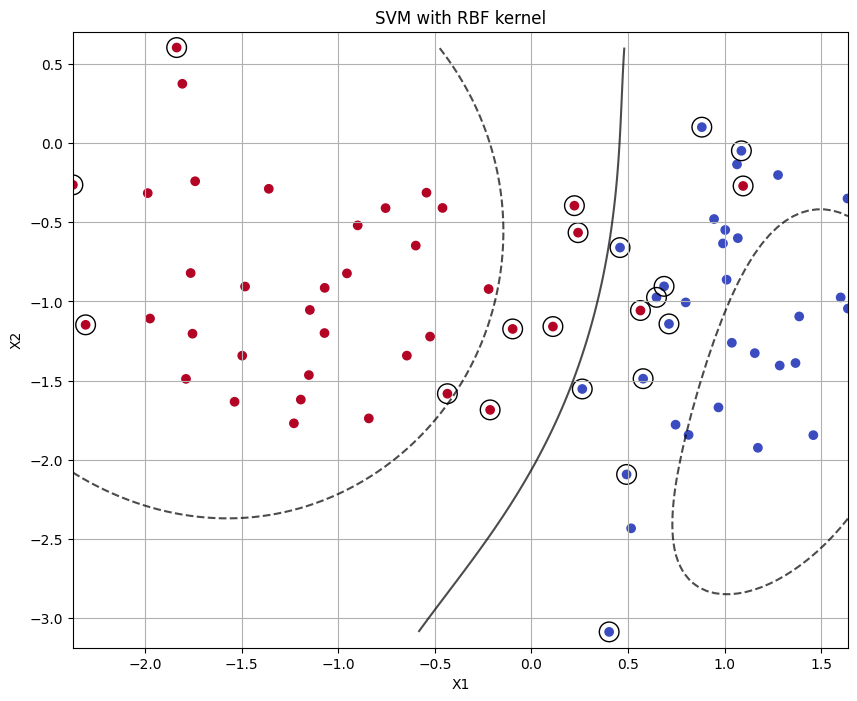

In [60]:
y_min, y_max = np.min(X[:, 1])-0.1, np.max(X[:, 1])+0.1

plt.figure(figsize=(10, 8))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm')
plt.contour(X0, X1, Z+1, colors='k', levels=[0], alpha=0.7, linestyles='--', extend='both')
plt.contour(X0, X1, Z, colors='k', levels=[0], alpha=0.7, linestyles='-', extend='both')
plt.contour(X0, X1, Z-1, colors='k', levels=[0], alpha=0.7, linestyles='--', extend='both')
plt.scatter(sv_x[:, 0], sv_x[:, 1], s=200, facecolors='none', edgecolors='k', label='Wektory wspierające')
plt.title('SVM with RBF kernel')
plt.xlabel('X1')
plt.ylabel('X2')
plt.ylim(y_min, y_max)
plt.grid(True)
plt.show()

In [61]:
conf_matrix_anl, sensitivity_anl, specificity_anl = metrics(y_test, y_pred)

print("conf_matrix:")
print(conf_matrix_anl)
print("sensitivity:", sensitivity_anl)
print("specificity:", specificity_anl)

conf_matrix:
[[18  1]
 [ 1 10]]
sensitivity: 0.9090909090909091
specificity: 0.9473684210526315


##POLY

In [62]:
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0,
                            n_clusters_per_class=1, random_state=254468)
y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=254468)

In [63]:
sv_x, sv_y, sv_lambda, b, w = SVM(X_train, y_train, kernel=poly_kernel)

y_pred = pred(X_test, sv_x, sv_y, sv_lambda, b, kernel=poly_kernel)

x0 = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
x1 = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 100)
X0, X1 = np.meshgrid(x0, x1)
XX = np.array([X0.ravel(), X1.ravel()]).T

Z = calculate_decision_boundary(XX, sv_x, sv_y, sv_lambda, b, poly_kernel)
Z = Z.reshape(X0.shape)

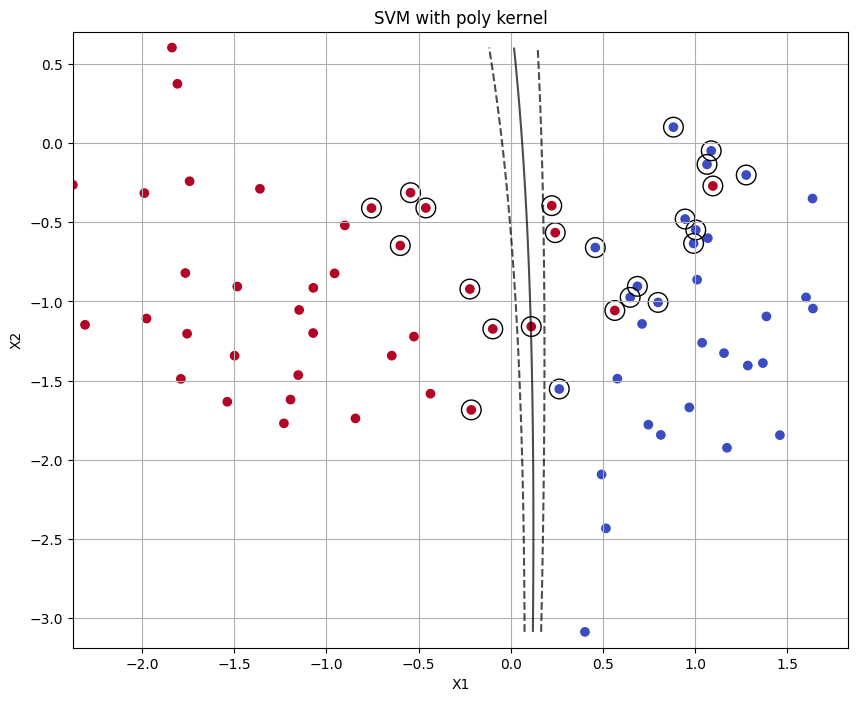

In [64]:
y_min, y_max = np.min(X[:, 1])-0.1, np.max(X[:, 1])+0.1

plt.figure(figsize=(10, 8))

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm')
plt.contour(X0, X1, Z, colors='k', levels=[-1], alpha=0.7, linestyles='--', extend='both')
plt.contour(X0, X1, Z, colors='k', levels=[0], alpha=0.7, linestyles='-', extend='both')
plt.contour(X0, X1, Z, colors='k', levels=[1], alpha=0.7, linestyles='--', extend='both')
plt.scatter(sv_x[:, 0], sv_x[:, 1], s=200, facecolors='none', edgecolors='k', label='Wektory wspierające')
plt.title('SVM with poly kernel')
plt.xlabel('X1')
plt.ylabel('X2')
plt.ylim(y_min, y_max)
plt.grid(True)
plt.show()

In [65]:
conf_matrix_anl, sensitivity_anl, specificity_anl = metrics(y_test, y_pred)

print("conf_matrix:")
print(conf_matrix_anl)
print("sensitivity:", sensitivity_anl)
print("specificity:", specificity_anl)

conf_matrix:
[[18  1]
 [ 0 11]]
sensitivity: 1.0
specificity: 0.9473684210526315
